In [598]:
import collections

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import kipoi
import os
import pybedtools
import torch
import h5sparse

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

import sys

# Define Paths for this user

In [599]:
########################## PATHS ###########################
# path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# data processing
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"
dnase_preprocessed_path = "/data/akmorrow/epitome_data/processed_dnase/"
feature_path = "/home/eecs/akmorrow/epitome/data/feature_name"

_DEEPSEA_GENOME_REGIONS_FILENAME = "/home/eecs/akmorrow/epitome/data/allTFs.pos.bed"

# DNase filepath dictionary
prefix_ =  "/data/akmorrow/encode_data/"

In [609]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())

# Load Data

### Load DeepSEA data

In [601]:
train_data, valid_data, test_data = load_deepsea_data(deepsea_path)

print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(408000, 4, 1000) (4000000, 4, 1000) (455024, 4, 1000)
(919, 408000) (919, 4000000) (919, 455024)


### Load Cut Sites

In [602]:
### Load DNase data
dnase_train = h5sparse.File(os.path.join(dnase_preprocessed_path, "processed_dnase_train_sparse.h5"))
dnase_valid = h5sparse.File(os.path.join(dnase_preprocessed_path, "processed_dnase_valid_sparse.h5"))
dnase_test  = h5sparse.File(os.path.join(dnase_preprocessed_path, "processed_dnase_test_sparse.h5"))

In [603]:
%%time

# process cut sites to dictionary of (key: celltype, value: csr_matrix)
dnase_train_dict = toSparseIndexedDictionary(dnase_train, dnase_valid_dnase_test, Dataset.TRAIN)
dnase_valid_dict = toSparseIndexedDictionary(dnase_train, dnase_valid_dnase_test, Dataset.VALID)
dnase_test_dict = toSparseIndexedDictionary(dnase_train, dnase_valid_dnase_test, Dataset.TEST)

NameError: name 'dnase_valid_dnase_test' is not defined

# Choose cell types

['K562', 'GM12878', 'H1-hESC', 'HepG2', 'HeLa-S3', 'A549', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116'] ['DNase', 'CTCF', 'Pol2', 'YY1', 'p300', 'TAF1', 'Pol2-4H8', 'c-Myc', 'Rad21', 'Max', 'NRSF', 'GABP', 'EZH2', 'CEBPB', 'c-Jun', 'ZBTB33', 'USF2', 'USF-1', 'TBP', 'RFX5']


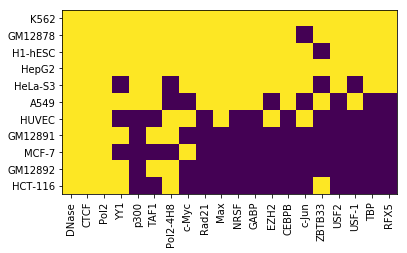

In [604]:
# matrix is cell types by factors, contains indices in feature vector
matrix, cellmap, assaymap = get_assays_from_feature_file()

inv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys())[:11], list(assaymap.keys())[:20])

# Select train, valid and test cell types

- test on A549
- train/validate on K562 and HepG2
- use remaining cell types as feature input 

In [605]:
# A549 is for test. 12 available features
test_celltypes = ["A549"]

valid_y_indices = np.copy(matrix[cellmap['A549']])
valid_holdout_indices = np.where(valid_y_indices == -1)[0]
# TODO: need the vectors to be the same length, but you should not evaluate on these
# Currently, set -1's to 0 these will all be evaluated on the DNase
valid_y_indices[matrix[cellmap['A549']] ==-1]=0

# K562, HepG2 indices is for train/valid. 19 available features
evaluation_celltypes = ["K562", "HepG2"] 
y_indices = [matrix[cellmap['K562']][matrix[cellmap['K562']]!=-1], 
             matrix[cellmap['HepG2']][matrix[cellmap['HepG2']]!=-1]]

# indices_mat is used to pull the remaining indices from cell types not used for prediction.
# delete evaluation cell types from the matrix (A549, HepG2 and K562)
indices_mat = np.delete(matrix, [0,3,5], axis=0)

# get all feature locations for DNase for remaining cell types (just the first column in matrix)
dnase_indices = indices_mat[:,0] # for all of the cell types (including the cell type we are evaluating)
indices = indices_mat[indices_mat!=-1]

# cell types not used in validation
train_celltypes = ['GM12878', 'H1-hESC', 'HeLa-S3', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116']


# Data Generators

## Generator with just processed DNase

In [606]:

### Distance functions
def gen(data, DATA_LABEL, radii=[1,3]):
    def g():
        
        # determines which indices to use for labels
        if (DATA_LABEL == Dataset.TEST):
            y_index_vector = [valid_y_indices]
        else:
            y_index_vector = y_indices
            
        if (len(radii) > 0):
            range_ = range(max(radii), data["y"].shape[-1]-max(radii))
        else: 
            range_ = range(0, data["y"].shape[-1])
 
        for i in range_: # for all records
            for y_index in y_index_vector:
                dnases = [] 
                for radius in radii:
                    # within the radius, fraction of places where they are both 1
                    dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    
                    # within the radius, fraction of places where they are both equal (0 or 1)
                    dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    dnases.extend(dnase_double_positive)
                    dnases.extend(dnase_agreement)
                    
                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                y_index_no_dnase = np.delete(y_index, [0])
                yield np.concatenate([data["y"][indices,i],dnases]), data["y"][y_index_no_dnase,i] 
    return g

def make_dataset(data,
                 which_dataset,
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):

    generator = gen(data, which_dataset, radii)
    
    for x, y in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2,
        output_shapes=(x.shape, y.shape,)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()


## Raw DNase Generator

In [632]:
def gen_dnase(data, DATA_LABEL, radii, chunk_size = 1):
    def g():
        # determines which indices to use for labels
        if (DATA_LABEL == Dataset.TEST):
            celltypes = test_celltypes
            y_index_vector = [valid_y_indices]
        else:
            celltypes = evaluation_celltypes
            y_index_vector = y_indices
            
            
        if (len(radii) > 0):
            start = max(radii)
            end = data["y"].shape[-1]-max(radii)
        else: 
            start = 0
            end = data["y"].shape[-1]
            range_ = range(start, end)
        
        ## TODO memory error need to chunk the ranges
        start_ = start
        while (start_ < end):
            end_ = min(start + chunk_size, end)
            range_ = range(start_, end_)

            # for all cells in either train or test
            for cell_i in range(0, len(celltypes)): # for each y_index [K562, HepG2], or [A549] if test

                celltype = celltypes[cell_i]
                y_index = y_index_vector[cell_i]

                # get dnase for this cell type
                dnase_i = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict,
                                                         range_,celltype, DATA_LABEL=DATA_LABEL)

                dnases = np.empty((len(range_), len(train_celltypes)))

                # compare to all other cell types
                train_i = 0
                for train_celltype in train_celltypes: 

                    dnase_j = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict, 
                                                            range_, train_celltype, DATA_LABEL=DATA_LABEL)


                    var_difference = abs(np.var(dnase_i.toarray(), axis=1) - np.var(dnase_j.toarray(), axis=1))

                    dnases[:,train_i] = var_difference
                    train_i+=1

                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                y_index_no_dnase = np.delete(y_index, [0])
                print(dnases.shape)
                print(data["y"].shape)

                for i in range(start, end_):
                    yield np.concatenate([data["y"][indices,i].T,dnases[i,:]]), data["y"][y_index_no_dnase, i]
                
            start += chunk_size

    return g

def make_dataset_dnase(data,
                 which_dataset, # Dataset enum
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):
    
    generator = gen_dnase(data, which_dataset, radii)
    
    for x, y in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2,
        output_shapes=(x.shape, y.shape,)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()




# Testing times for DNase generator

With DNase, it is about 30 times slower with chunk size of 200,000 :(

In [ ]:
%%time 
generator = gen_dnase(valid_data, Dataset.VALID, radii=[], chunk_size=200000)()

x1=list(generator)

In [ ]:
%%time 

generator2 = gen(valid_data, Dataset.VALID, radii=[])()
x2=list(generator2)

# Check how DeepSea does

In [4]:
model = kipoi.get_model('DeepSEA/predict')
batch_size = 100
preds = []
for i in np.arange(0, len(valid_data["x"]), batch_size):
    batch = valid_data["x"][i:i+batch_size]
    batch = np.expand_dims(batch, 2)
    batch = batch[:,[0,2,1,3]]
    preds.append(model.predict_on_batch(batch.astype(np.float32)))
preds = np.concatenate(preds, axis=0)

NameError: name 'valid_data' is not defined

### Direct performance of DeepSea

In [ ]:
# for i in range(20):
print(valid_data["y"][y_indices[0]].shape)
print(preds.T[y_indices[0]].shape)
sklearn.metrics.roc_auc_score(valid_data["y"][y_indices[0]].T, preds.T[y_indices[0]].T, average="macro")

### Performance of DeepSea through averaging

In [12]:
weights = np.tile((indices_mat!=-1).reshape(indices_mat.shape + (1,)), (1, 1, valid_data["y"].shape[-1]))

average_preds = np.average(preds.T[indices_mat], axis=0, weights=weights)
average_preds = np.concatenate([average_preds,average_preds],axis=1)

truth = np.concatenate([valid_data["y"][y_indices[0]],valid_data["y"][y_indices[1]]],axis=1)

print("Macro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='macro'))
print("Micro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='micro'))
for i in range(len(truth)):
    print(i, sklearn.metrics.roc_auc_score(truth[i].T, average_preds[i].T, average='macro'))

NameError: name 'preds' is not defined

# Model definition

In [539]:
class Model():
    def __init__(self,
                 train_data,
                 valid_data,
                 test_data,
                 batch_size=64,
                 shuffle_size=10000,
                 prefetch_size=10,
                 l1=0.,
                 l2=0.,
                 lr=1e-3,
                 radii=[1,3]):
        
        self.graph = tf.Graph()

        with self.graph.as_default() as graph:
            tf.logging.set_verbosity(tf.logging.INFO)

            output_shape, train_iter = make_dataset_dnase(train_data,  Dataset.TRAIN, batch_size, shuffle_size, prefetch_size, radii)
            _,            valid_iter = make_dataset_dnase(valid_data, Dataset.VALID, batch_size, 1           , prefetch_size, radii)
            _,            test_iter = make_dataset_dnase(test_data, Dataset.TEST, batch_size, 1           , prefetch_size, radii)

            #### Weston uncomment to run original method
            #output_shape, train_iter = make_dataset(train_data,  Dataset.TRAIN, batch_size, shuffle_size, prefetch_size, radii)
            #_,            valid_iter = make_dataset(valid_data, Dataset.VALID, batch_size, 1           , prefetch_size, radii)
            #_,            test_iter = make_dataset(test_data, Dataset.TEST, batch_size, 1           , prefetch_size, radii)

            self.train_handle = train_iter.string_handle()
            self.valid_handle = valid_iter.string_handle()
            self.test_handle = test_iter.string_handle()
            
            self.handle = tf.placeholder(tf.string, shape=[])
            iterator = tf.data.Iterator.from_string_handle(
                self.handle, train_iter.output_types, train_iter.output_shapes)
            self.x, self.y = iterator.get_next()
            
            self.sess = tf.InteractiveSession(graph=graph)

            self.num_outputs = output_shape[0]
            self.l1, self.l2 = l1, l2
            self.default_lr = lr
            self.lr = tf.placeholder(tf.float32)
            self.batch_size = batch_size
            self.prefetch_size = prefetch_size

            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self.logits = self.body_fn()
            self.predictions = tf.sigmoid(self.logits)
            self.loss = self.loss_fn()
            self.min = self.minimizer_fn()
            
            self.closed = False
                
    def body_fn(self):
        raise NotImplementedError()
    
    def loss_fn(self):
        return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.y, self.logits, 50))
    
    def minimizer_fn(self):
        self.opt = tf.train.AdamOptimizer(self.lr)
        return self.opt.minimize(self.loss, self.global_step)
    
    def close():
        if not self.closed:
            self.sess.close()
        self.closed = True
        
    def train(self, num_steps, lr=None):
        assert not self.closed
        with self.graph.as_default():
            if lr == None:
                lr = self.default_lr
            try:
                self.sess.run(self.global_step)
            except:
                tf.logging.info("Initializing variables")
                self.sess.run(tf.global_variables_initializer())
                self.train_handle = self.sess.run(self.train_handle)
                self.valid_handle = self.sess.run(self.valid_handle)
                self.test_handle = self.sess.run(self.test_handle)

            max_steps = self.sess.run(self.global_step) + num_steps

            tf.logging.info("Starting Training")

            while self.sess.run(self.global_step) < max_steps:
                _, loss = self.sess.run([self.min, self.loss], {self.handle: self.train_handle, self.lr: lr})
                step = self.sess.run(self.global_step)
                if step % 1000 == 0:
                    tf.logging.info(str(step) + " " + str(loss))
                    tf.logging.info("On validation")
                    _, _, _, _, stop = self.test(40000, log=False)
                    if stop: break
                    tf.logging.info("")
                
    def test(self, num_samples, mode = Dataset.VALID, log=False, iterator_handle=None):
        if (mode == Dataset.VALID):
            handle = self.valid_handle
            validation_indices = []
        elif (mode == Dataset.TEST):
            handle = self.test_handle
            validation_indices = valid_holdout_indices # indices of assays not available for A549
        else:
            raise
            
        assert not self.closed
        with self.graph.as_default():
            vals = []
            for i in range(int(num_samples / self.batch_size)):
                vals.append(
                    self.sess.run([self.predictions, self.x, self.y],
                             {self.handle: iterator_handle if iterator_handle else handle})
                )
            preds = np.concatenate([v[0] for v in vals])
            truth = np.concatenate([v[2] for v in vals])

            # remove missing indices for computing macro/micro AUC
            preds_r = np.delete(preds, validation_indices, axis=1)
            truth_r = np.delete(truth, validation_indices, axis=1)

            macroAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='macro')
            microAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='micro')
            tf.logging.info("Our macro AUC:     " + str(macroAUC))
            tf.logging.info("Our micro AUC:     " + str(microAUC))
            if log:
                for i in range(matrix.shape[1]-1): # eval on all assays except DNase
                    assay = inv_assaymap[i+1]
                    
                    if (i not in validation_indices):
                        print(assay, sklearn.metrics.roc_auc_score(truth[:,i], preds[:,i], average='macro'))
                    else:
                        print(assay, np.NaN)
                        
                
            return preds, truth, microAUC, macroAUC, False

class MLP(Model):
    def __init__(self,
             layers,
             num_units,
             activation,
             *args,
             **kwargs):

        self.layers = layers
        self.num_units = num_units
        self.activation = activation
        
        Model.__init__(self, *args, **kwargs)
            
    def body_fn(self):
        model = self.x
        
        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
            
        for i in range(self.layers):
            model = tf.layers.dense(model, self.num_units[i], self.activation)#, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))
        
        return tf.layers.dense(model, self.num_outputs, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))

        

# Run with DNase

In [540]:
results = []
model = MLP(4, [100, 100, 100, 50], tf.tanh, train_data, valid_data, test_data, shuffle_size=2, radii=[])
model.train(20000)
results.append(model.test(455024, mode = Dataset.TEST, log=True))

IndexError: index (3999999) out of range

In [ ]:
results.append(model.test(8000, mode = Dataset.VALID, log=True))

In [84]:
results.append(model.test(455024, mode = Dataset.TEST, log=True))

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:117: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:118: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


INFO:tensorflow:Our macro AUC:     0.8309258938344021
INFO:tensorflow:Our micro AUC:     0.7385998286731957
CTCF 0.9463942584876804
Pol2 0.9588636515756777
YY1 0.8795148035379846
p300 0.7733681113763502
TAF1 0.8986777813598592
Pol2-4H8 0.6383651317594076
c-Myc nan
Rad21 nan
Max 0.9520859570904386
NRSF 0.8430683942821179
GABP 0.8771481865354318
EZH2 0.8137260413710268
CEBPB nan
c-Jun 0.679424019322199
ZBTB33 nan
USF2 0.7662017148532945
USF-1 nan
TBP 0.7751985682957584
RFX5 nan


(array([[0.04675665, 0.09816638, 0.03188987, ..., 0.06927536, 0.0769244 ,
         0.02396182],
        [0.04579303, 0.09859513, 0.03165828, ..., 0.06940596, 0.07659425,
         0.02368902],
        [0.04514086, 0.0989252 , 0.03144021, ..., 0.06961869, 0.07639512,
         0.02335319],
        ...,
        [0.05365978, 0.09488048, 0.03316782, ..., 0.06903983, 0.07963464,
         0.02611261],
        [0.05361602, 0.0949579 , 0.03315456, ..., 0.06905258, 0.07961825,
         0.02603792],
        [0.19578336, 0.1216448 , 0.11400988, ..., 0.04941948, 0.12397033,
         0.02289581]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 0.7385998286731957, 0.8309258938344021, False)

In [104]:
for preds, truth, _ in results:
    print(sklearn.metrics.roc_auc_score(truth, preds, average='macro'))
    print(sklearn.metrics.roc_auc_score(truth, preds, average='micro'))

ValueError: too many values to unpack (expected 3)

In [ ]:
# 20k steps, take maximum macroAUC observed during training
#2, [100, 50], [0], 0.9012855730483059
#2, [100, 50], [1], 0.9185077245227484
#2, [100, 50], [1,3], 0.9207317913067318
#2, [100, 50], [1,3,10], 0.9206390991622936
#2, [100, 50], [1,3,10,30], 0.9241529096459893
